In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import signal, stats, fftpack, integrate
from glob import glob
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, get_evoked_firing_rates

In [5]:
%matplotlib notebook

## Functions

In [6]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

## Load experiment instance

In [7]:
dfolder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1'
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

### Load EEG data and adjusted stimulus log

In [9]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

In [10]:
stim_log, good_chs = exp.qualitycheck_trials_chs()
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,biphasic,30,313.21234,313.21274,0.0004,0,True
1,biphasic,10,317.12436,317.12476,0.0004,0,True
2,biphasic,10,321.22743,321.22783,0.0004,0,True
3,biphasic,50,325.47838,325.47878,0.0004,0,True
4,biphasic,50,329.56234,329.56274,0.0004,0,True


### Stim evoked traces

In [11]:
plot_before = 1.0 # s, look at 100 ms pre-stim
plot_after = 1.0 # s, look at 500 ms post-stim

low_pass_cutoff = 100
apply_blsub = False

In [68]:
## Loop through all stim events/sweeps and collect traces, common avg, and filtered
traces = {}
comavg_traces = {}
filtered_traces = {}
filtered_comavg_traces = {}

for st_type in stim_log.stim_type.unique():
    traces[st_type] = {}
    comavg_traces[st_type] = {}
    filtered_traces[st_type] = {}
    filtered_comavg_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        traces[st_type][parami] = {}
        comavg_traces[st_type][parami] = {}
        filtered_traces[st_type][parami] = {}
        filtered_comavg_traces[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            if len(events) == 0:
                print('{} {}, sweep {:d}: no good trials found'.format(st_type, str(parami), sweepi))
                continue
            print('{} {}, sweep {:d}: {:d} good trials'.format(st_type, str(parami), sweepi, events.shape[0]))
            GOOD_CHS = good_chs[st_type][parami][sweepi]
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            
            comavg_event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
             # design lowpass filter
            filtb, filta = signal.butter(3, 100/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
            # apply filter
            if apply_blsub:
                blinds = np.squeeze(np.argwhere((event_ts > -0.2) & (event_ts < -0.005)))
                filttraces = signal.filtfilt(filtb, filta, event_traces - np.mean(event_traces[blinds,:,:], axis=0), axis=0)
                cafilttraces = signal.filtfilt(filtb, filta, comavg_event_traces - np.mean(comavg_event_traces[blinds,:,:], axis=0), axis=0)
            else:
                filttraces = signal.filtfilt(filtb, filta, event_traces, axis=0)
                cafilttraces = signal.filtfilt(filtb, filta, comavg_event_traces, axis=0)
            
            ## Store traces ##
            traces[st_type][parami][sweepi] = [event_ts, event_traces]
            comavg_traces[st_type][parami][sweepi] = [event_ts, comavg_event_traces]
            filtered_traces[st_type][parami][sweepi] = [event_ts, filttraces]
            filtered_comavg_traces[st_type][parami][sweepi] = [event_ts, cafilttraces]

biphasic 10, sweep 0: 120 good trials
biphasic 10, sweep 1: 120 good trials
biphasic 10, sweep 2: 120 good trials
biphasic 10, sweep 3: 120 good trials
biphasic 30, sweep 0: 120 good trials
biphasic 30, sweep 1: 120 good trials
biphasic 30, sweep 2: 120 good trials
biphasic 30, sweep 3: 120 good trials
biphasic 50, sweep 0: 120 good trials
biphasic 50, sweep 1: 120 good trials
biphasic 50, sweep 2: 120 good trials
biphasic 50, sweep 3: 120 good trials
circle white, sweep 0: 120 good trials
circle white, sweep 1: 120 good trials
circle white, sweep 2: 120 good trials


### Plotting

Plot butterfly for one event

<IPython.core.display.Javascript object>


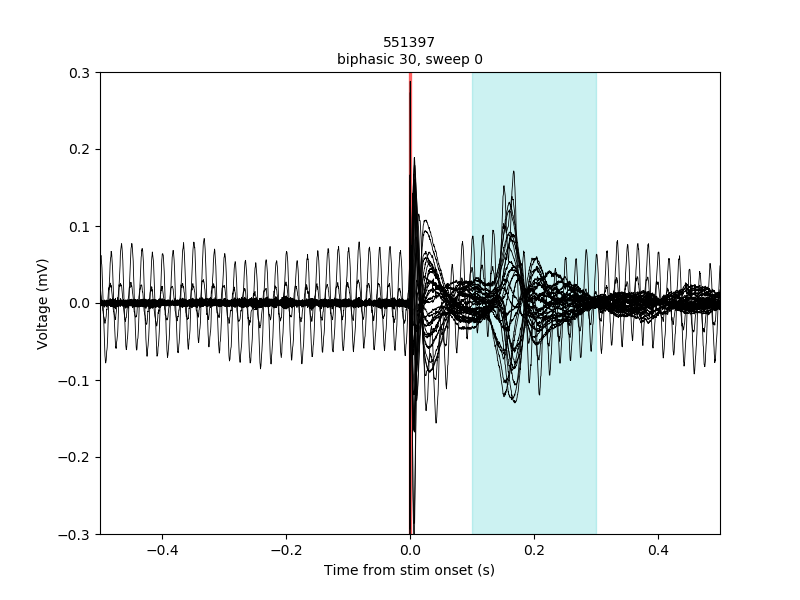

Text(0.5, 1.0, '551397\nbiphasic 30, sweep 0')

In [13]:
pick_stim = 'biphasic'
pick_param = '30'
pick_sweep = 0
pick_traces = comavg_traces # avg_traces or avg_filtered_traces or filtered_comavg_traces

prex = .5 # ms before stim to plot
postx = .5 # ms after stim to plot
ylimit = 0.3 # mV

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = np.mean(pick_traces[pick_stim][pick_param][pick_sweep][1], axis=2)/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-.001, .001, color='r', alpha=0.5)
ax.axvspan(.1, .3, color='c', alpha=0.2)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

<IPython.core.display.Javascript object>


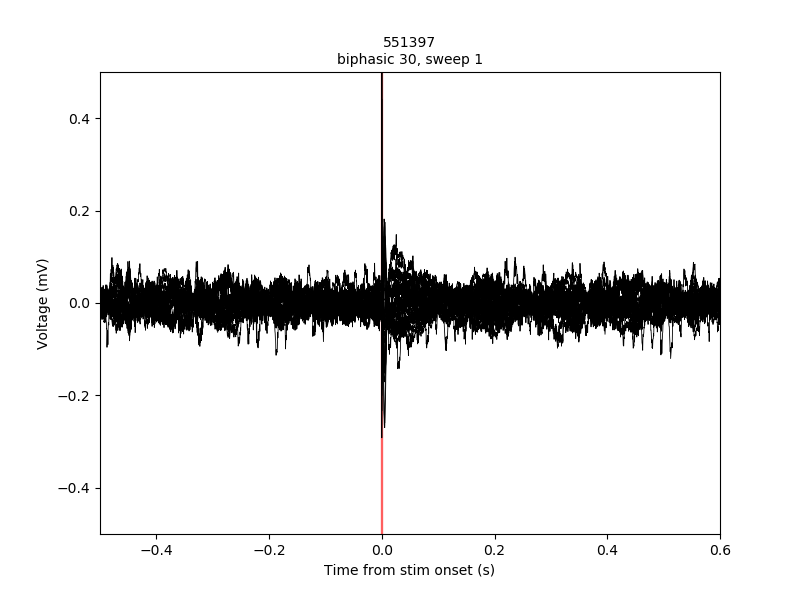

Text(0.5, 1.0, '551397\nbiphasic 30, sweep 1')

In [15]:
## single trials ##
pick_stim = 'biphasic'
pick_param = '30'
pick_sweep = 1
pick_traces = comavg_traces # traces, comavg_traces, filtered_traces, filtered_comavg_traces

prex = .5 # ms before stim to plot
postx = .6 # ms after stim to plot
ylimit = 0.5 # mV

GOOD_CHS = good_chs[pick_stim][pick_param][pick_sweep]
timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1][:,GOOD_CHS,:]/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(timex[plot_inds], plottraces[plot_inds,:,6], color='k', linewidth=0.6)
ax.axvspan(-.001, .001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

### Quatification of evoked response

Ideas from the Luck book chapter:
- max value in window
- mean value in window (measure mean amplitude prior to applying filter)

Compare distributions of max(abs(signal_window))

Compare distributions of mean(abs(signal_window))

Compare distributions of mean(signal_window)

Compare distributions of rms(signal_window): using np.sqrt(np.mean(y**2))

Compare distributions of AUC(abs(signal_window))

<IPython.core.display.Javascript object>


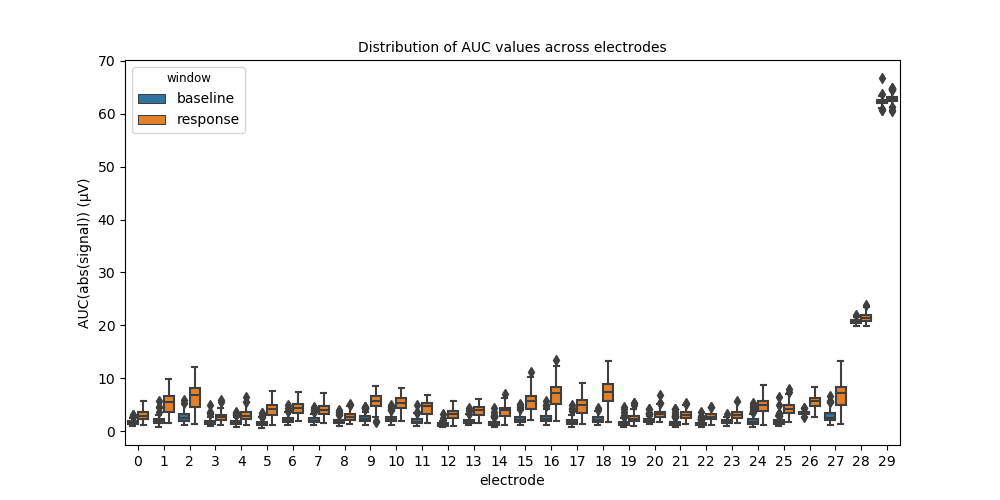

Text(0.5, 1.0, 'Distribution of AUC values across electrodes')

In [17]:
stimi = 'biphasic'
parami = '30'
sweepi = 0
trace_data = comavg_traces # traces or filtered_traces

prewin = [-0.2, -0.1] # [-0.5, -0.005], [-0.2, -0.1]
postwin = [0.1, 0.2] # [0.005, 0.5], [0.1, 0.2]
timex = trace_data[stimi][parami][sweepi][0]

## Find auc values in baseline ##
preinds = np.squeeze(np.argwhere((timex >= prewin[0]) & (timex <= prewin[1])))
baseline_auc = integrate.simps(np.abs(trace_data[stimi][parami][sweepi][1][preinds, :, :]), timex[preinds], axis=0, even='last')

## Find auc values in response ##
postinds = np.squeeze(np.argwhere((timex >= postwin[0]) & (timex <= postwin[1])))
response_auc = integrate.simps(np.abs(trace_data[stimi][parami][sweepi][1][postinds, :, :]), timex[postinds], axis=0, even='last')

## Make dataframe for plotting ##
auc_list = []
period_list = []
ch_list = []
for cha in eeg_chs:
    # baseline #
    auc_list.append(baseline_auc[cha, :])
    period_list.append(['baseline'] * baseline_auc.shape[1])
    ch_list.append([cha] * baseline_auc.shape[1])
    # response #
    auc_list.append(response_auc[cha, :])
    period_list.append(['response'] * response_auc.shape[1])
    ch_list.append([cha] * response_auc.shape[1])
df = pd.DataFrame({'auc': np.concatenate(auc_list), 'window': np.concatenate(period_list), 'electrode': np.concatenate(ch_list)})

## box plot ##
fig, ax = plt.subplots(figsize=(10,5))
bxplt = sns.boxplot(x='electrode', y='auc', hue='window', data=df, ax=ax)
bxplt.set_ylabel('AUC(abs(signal)) (\u03BCV)')
bxplt.set_title('Distribution of AUC values across electrodes')

### Comparisons between amplitudes

<IPython.core.display.Javascript object>


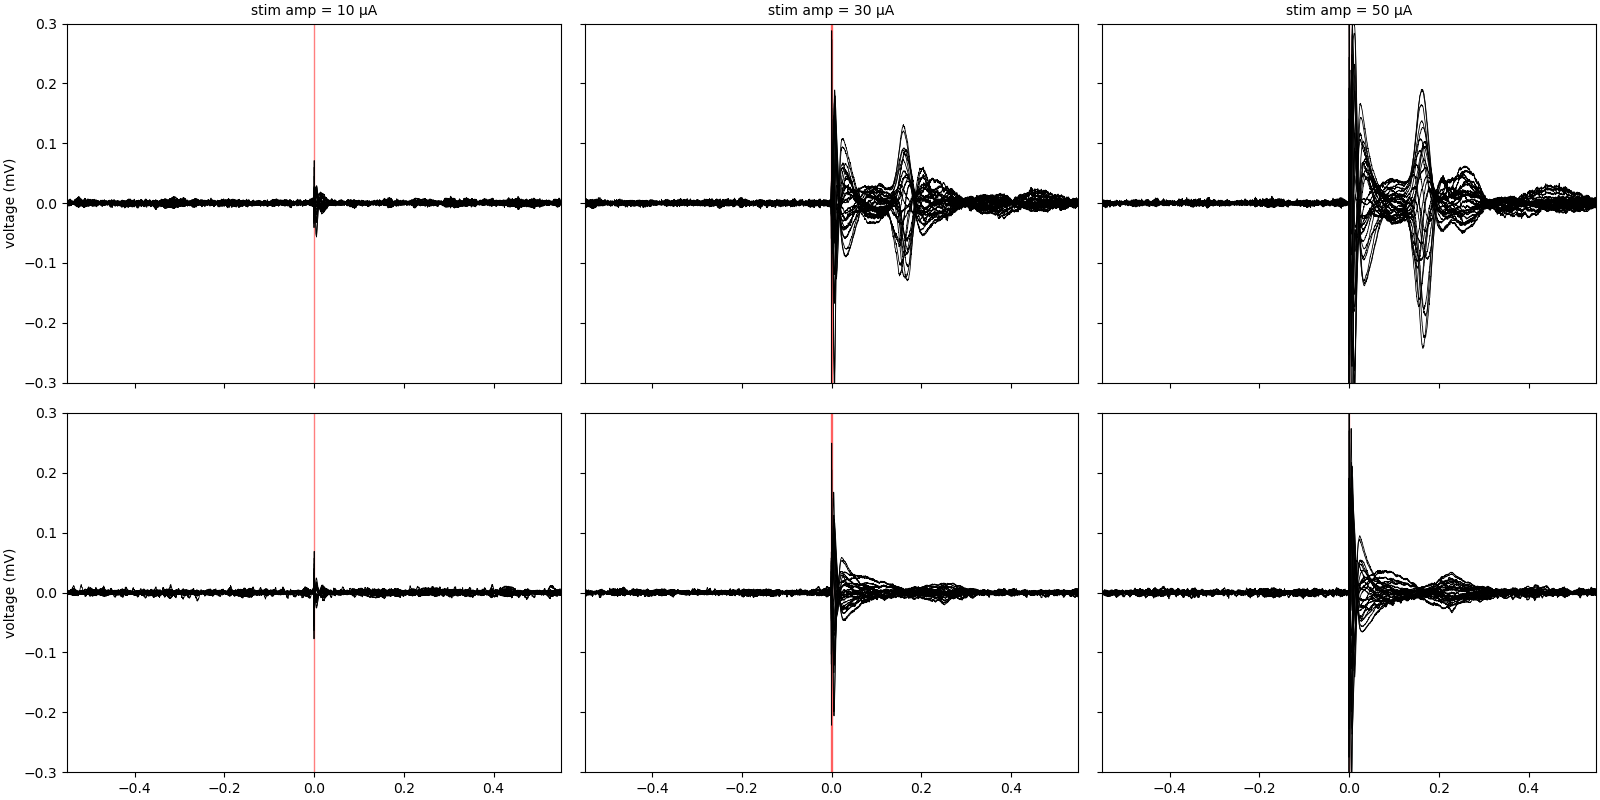

(-0.3, 0.3)

In [20]:
stimi = 'biphasic'
plot_sweeps = [0, 1]
plot_traces = comavg_traces # avg_traces or avg_filtered_traces

prex = .55 # ms before stim to plot
postx = .55 # ms after stim to plot
ylimit = 0.3 # mV

fig, axs = plt.subplots(len(plot_sweeps), len(plot_traces[stimi].keys()), figsize=(16,8), sharex=True, sharey=True, constrained_layout=True)
for sweepi in plot_sweeps:
    for col, parami in enumerate(plot_traces[stimi].keys()):
        GOOD_CHS = good_chs[stimi][parami][sweepi]
        timex = plot_traces[stimi][parami][sweepi][0]
        plottraces = np.mean(plot_traces[stimi][parami][sweepi][1], axis=2)[:, GOOD_CHS]/1000 # make them into mV
        plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

        axs[sweepi,col].plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
        axs[sweepi,col].axvspan(-.001, .001, color='r', alpha=0.5)
        
        if col == 0:
            axs[sweepi,col].set_ylabel('voltage (mV)')
        if sweepi == 0:
            axs[sweepi,col].set_title('stim amp = {:s} \u03BCA'.format(parami))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-ylimit, ylimit])

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_comavgEEG_allamps.png'), transparent=True)

#### Choose random single trials

<IPython.core.display.Javascript object>


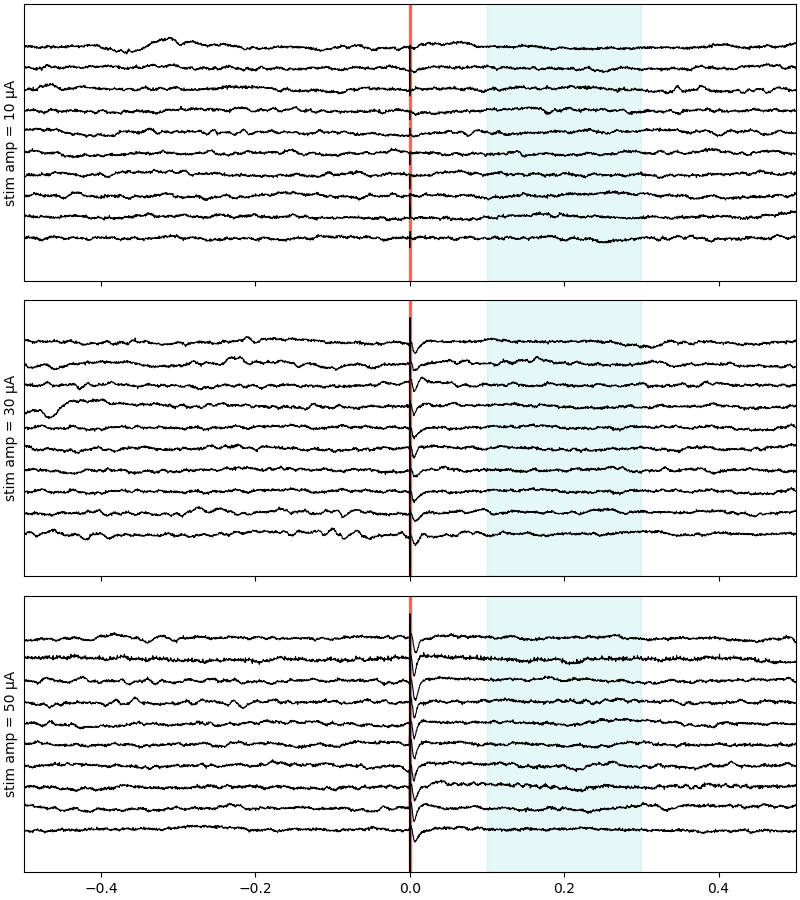

(-400, 2200)

In [22]:
stimi = 'biphasic'
sweepi = 1
cha = 12
plot_traces = comavg_traces # avg_traces or avg_filtered_traces

prex = .5 # s before stim to plot
postx = .5 # s after stim to plot
sep = 200

fig, axs = plt.subplots(len(plot_traces[stimi].keys()), 1, figsize=(16*0.5,9), sharex=True, sharey=True, constrained_layout=True)
for row, parami in enumerate(plot_traces[stimi].keys()):
    timex = plot_traces[stimi][parami][sweepi][0]
    plottraces = plot_traces[stimi][parami][sweepi][1][:,cha,:]
    plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))
    
    plot_trials = np.random.choice(range(plottraces.shape[-1]), 10)
    for tt, triali in enumerate(plot_trials):
        axs[row].plot(timex[plot_inds], plottraces[plot_inds,triali]+sep*tt, color='k', linewidth=0.8)
    axs[row].axvspan(-.001, .001, color='r', alpha=0.5)
    axs[row].axvspan(.1, .3, color='c', alpha=0.1)
    axs[row].set_ylabel('stim amp = {:s} \u03BCA'.format(parami))
    axs[row].set_yticks([])

axs[0].set_xlim([-prex, postx])
axs[0].set_ylim([-sep*2, sep*(tt+2)])

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_comavgEEG_singletrials_ch{:d}.png'.format(cha)), transparent=True)

#### mean signal

<IPython.core.display.Javascript object>


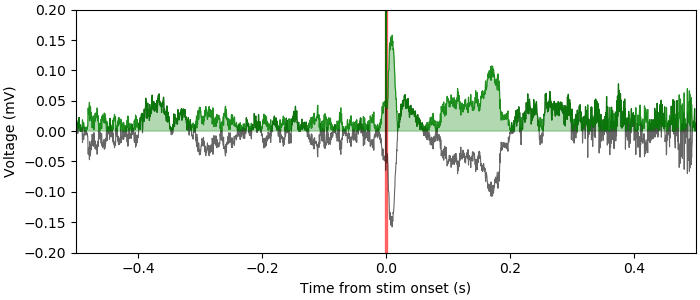

In [70]:
## single trial ##
pick_stim = 'biphasic'
pick_param = '50'
pick_sweep = 0
pick_traces = comavg_traces # traces, comavg_traces, filtered_traces, filtered_comavg_traces

prex = .5 # ms before stim to plot
postx = .5 # ms after stim to plot
ylimit = 0.2 # mV

timex = pick_traces[pick_stim][pick_param][pick_sweep][0]
plottraces = pick_traces[pick_stim][pick_param][pick_sweep][1]
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(7,3), constrained_layout=True)

# ax.plot(timex[plot_inds], plottraces[plot_inds,cha,6]/1000, color='k', linewidth=0.8)
# ax.fill_between(timex[plot_inds], plottraces[plot_inds,cha,6]/1000, where=(plottraces[plot_inds,cha,6]/1000 > 0), color='g', alpha=0.3)
# ax.fill_between(timex[plot_inds], plottraces[plot_inds,cha,6]/1000, where=(plottraces[plot_inds,cha,6]/1000 < 0), color='r', alpha=0.3)

ax.plot(timex[plot_inds], plottraces[plot_inds,cha,6]/1000, color='k', linewidth=0.8, alpha=0.6)
ax.plot(timex[plot_inds], np.abs(plottraces[plot_inds,cha,6]/1000), color='g', linewidth=0.8, alpha=0.8)
ax.fill_between(timex[plot_inds], np.abs(plottraces[plot_inds,cha,6]/1000), color='g', alpha=0.3)
ax.axvspan(-.001, .001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
# ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_comavgEEG_trialrectAUC_ch{:d}.png'.format(cha)), transparent=True)

#### mean abs signal

#### AUC integral

#### area under abs curve

<IPython.core.display.Javascript object>


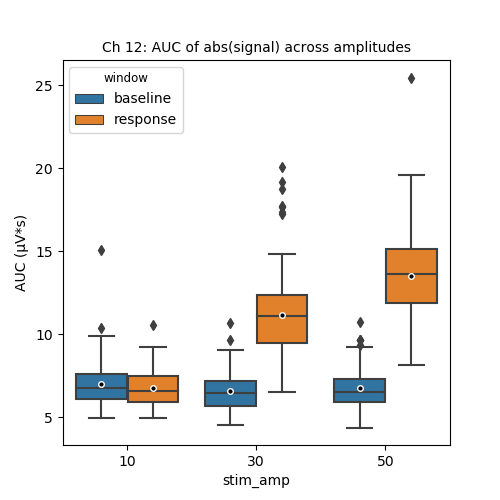

Text(0.5, 1.0, 'Ch 12: AUC of abs(signal) across amplitudes')

In [24]:
stimi = 'biphasic'
sweepi = 0
trace_data = comavg_traces # traces or filtered_traces

prewin = [-0.5, -0.005] # [-0.5, -0.005], [-0.2, -0.1]
postwin = [0.005, 0.5] # [0.005, 0.5], [0.1, 0.2]

auc_list = []
period_list = []
stim_amp_list = []
for parami in trace_data[stimi].keys():
    timex = trace_data[stimi][parami][sweepi][0]

    ## Find auc values in baseline ##
    preinds = np.squeeze(np.argwhere((timex >= prewin[0]) & (timex <= prewin[1])))
    baseline_auc = integrate.simps(np.abs(trace_data[stimi][parami][sweepi][1][preinds, cha, :]), timex[preinds], axis=0, even='last')

    ## Find auc values in response ##
    postinds = np.squeeze(np.argwhere((timex >= postwin[0]) & (timex <= postwin[1])))
    response_auc = integrate.simps(np.abs(trace_data[stimi][parami][sweepi][1][postinds, cha, :]), timex[postinds], axis=0, even='last')

    ## Make dataframe for plotting ##
    auc_list.append(baseline_auc)
    period_list.append(['baseline'] * baseline_auc.shape[0])
    stim_amp_list.append([parami] * baseline_auc.shape[0])
    
    auc_list.append(response_auc)
    period_list.append(['response'] * response_auc.shape[0])
    stim_amp_list.append([parami] * response_auc.shape[0])
    
df = pd.DataFrame({'auc': np.concatenate(auc_list), 'window': np.concatenate(period_list), 'stim_amp': np.concatenate(stim_amp_list)})

## Box plot ##
fig, ax = plt.subplots(figsize=(5,5))
bxplt = sns.boxplot(
    x='stim_amp',
    y='auc',
    hue='window',
    data=df,
    ax=ax,
    showmeans=True,
    meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'white', 'markersize':'8'}
)
bxplt.set_ylabel('AUC (\u03BCV*s)')
bxplt.set_title('Ch {:d}: AUC of abs(signal) across amplitudes'.format(cha))

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'AUC_abs_signal_ch{:d}.png'.format(cha)), transparent=True)

<IPython.core.display.Javascript object>


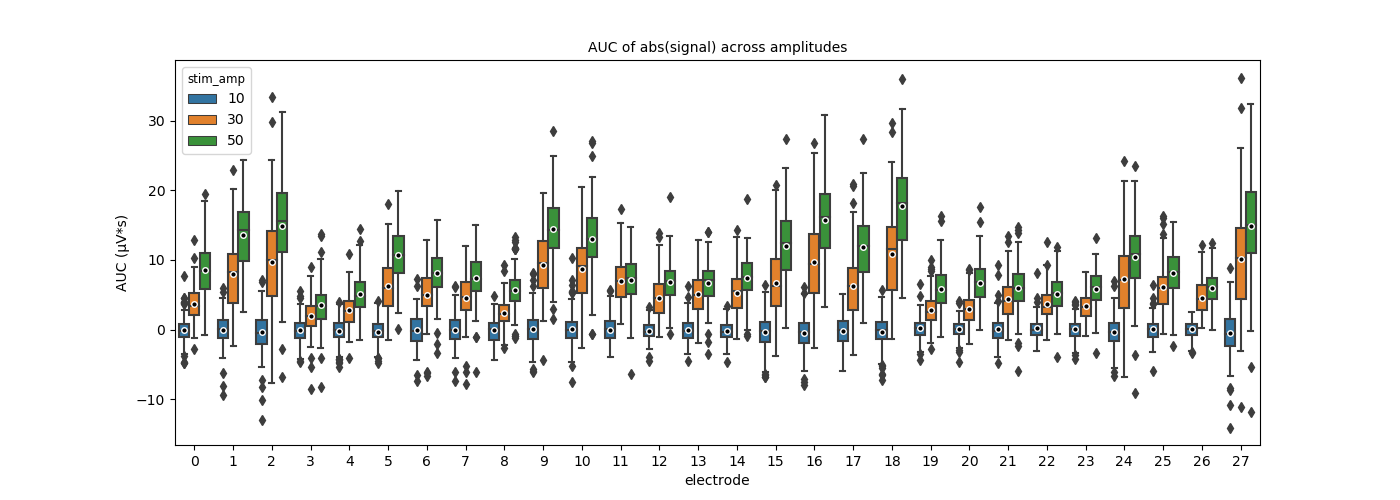

Text(0.5, 1.0, 'AUC of abs(signal) across amplitudes')

In [26]:
stimi = 'biphasic'
sweepi = 0
trace_data = comavg_traces # traces or filtered_traces

prewin = [-0.5, -0.005] # [-0.5, -0.005], [-0.2, -0.1]
postwin = [0.005, 0.5] # [0.005, 0.5], [0.1, 0.2]

auc_list = []
period_list = []
stim_amp_list = []
ch_list = []
for parami in trace_data[stimi].keys():
    timex = trace_data[stimi][parami][sweepi][0]
    
    ## Find auc values in baseline ##
    preinds = np.squeeze(np.argwhere((timex >= prewin[0]) & (timex <= prewin[1])))
    baseline_auc = integrate.simps(np.abs(trace_data[stimi][parami][sweepi][1][preinds, :, :]), timex[preinds], axis=0, even='last')

    ## Find auc values in response ##
    postinds = np.squeeze(np.argwhere((timex >= postwin[0]) & (timex <= postwin[1])))
    response_auc = integrate.simps(np.abs(trace_data[stimi][parami][sweepi][1][postinds, :, :]), timex[postinds], axis=0, even='last')

    for cha in good_chs[stimi][parami][sweepi]:
        ## Make dataframe for plotting ##
        auc_list.append(response_auc[cha, :] - baseline_auc[cha, :])
        stim_amp_list.append([parami] * response_auc.shape[1])
        ch_list.append([cha] * response_auc.shape[1])
    
df = pd.DataFrame({'auc': np.concatenate(auc_list), 'electrode': np.concatenate(ch_list), 'stim_amp': np.concatenate(stim_amp_list)})

## Box plot ##
fig, ax = plt.subplots(figsize=(14,5))
bxplt = sns.boxplot(
    x='electrode',
    y='auc',
    hue='stim_amp',
    data=df,
    ax=ax,
    showmeans=True,
    meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'white', 'markersize':'8'}
)
bxplt.set_ylabel('AUC (\u03BCV*s)')
bxplt.set_title('AUC of abs(signal) across amplitudes')

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'AUC_abs_signal_allchs.png'), transparent=True)

#### Compute AUC for individual trials and plot by rank

<IPython.core.display.Javascript object>


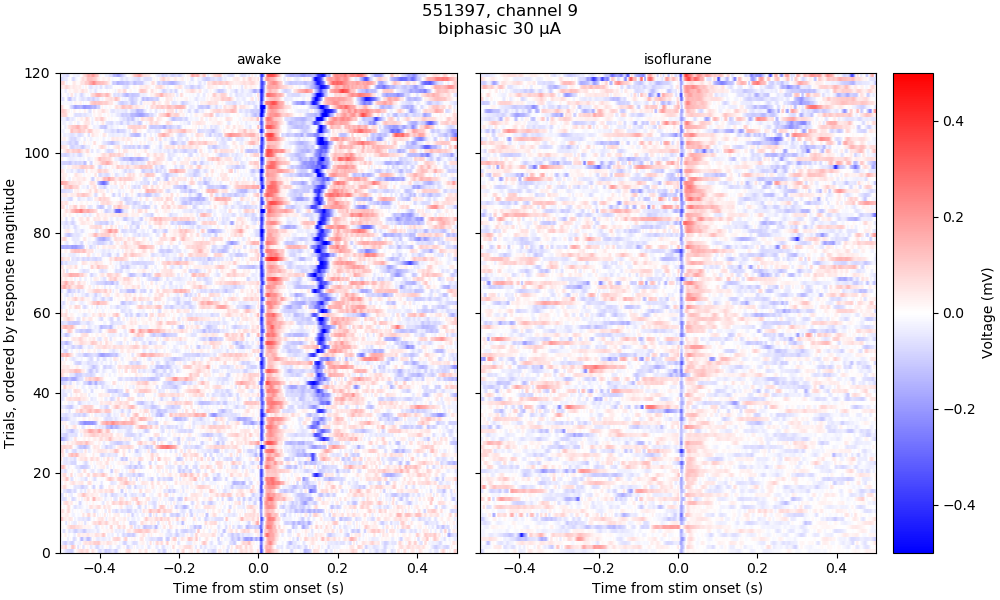

In [71]:
plot_traces = filtered_traces # avg_traces or filtered_traces or comavg_traces
cha = 9
stimi = 'biphasic'
parami = '30'
sweep_states = {0: 'awake', 1: 'isoflurane'}

plot_window = [-0.5, 0.5] # s before, after stim to plot
set_vrange = 0.5 # mV
auc_window = [0.005, 0.5] # [0.005, 0.5] [0.1, 0.3]

fig, axs = plt.subplots(1, len(sweep_states.keys()), figsize=(10,6), sharey=True, constrained_layout=True)

for ax, sweepi in zip(axs, sweep_states.keys()):
    timex = plot_traces[stimi][parami][sweepi][0]
    ptraces = plot_traces[stimi][parami][sweepi][1][:,cha,:]/1000
    
    ## rank by AUC(abs(response)) ##
    rinds = np.nonzero((timex >= auc_window[0]) & (timex <= auc_window[1]))[0]
    response_auc = integrate.simps(np.abs(ptraces[rinds, :]), timex[rinds], axis=0, even='last')
    
    pinds = np.nonzero((timex >= plot_window[0]) & (timex <= plot_window[1]))[0]
    
    trials_plot = ax.imshow(
        ptraces[pinds, :].T[np.squeeze(np.argsort(response_auc)), :],
        cmap='bwr',
        aspect='auto',
        interpolation='none',
        origin='lower',
        vmin=-set_vrange,
        vmax=set_vrange,
        extent=[plot_window[0], plot_window[1], 0, ptraces.shape[1]],
    )
#     ax.set_yticks(np.arange(len(realchs))+0.5)
#     ax.set_yticklabels(realchs, fontsize=8)
#     for ytick in ax.get_yticklabels():
#         if int(ytick.get_text()) in bad_chs[pick_mouse]:
#             ytick.set_color('r')
    ax.set_title('{}'.format(sweep_states[sweepi]))
    ax.set_xlabel('Time from stim onset (s)')
    
axs[0].set_ylabel('Trials, ordered by response magnitude')
cbar = plt.colorbar(trials_plot, ax=axs[1])
cbar.set_label('Voltage (mV)')
plt.suptitle('{}, channel {:d}\n{} {} \u03BCA'.format(exp.mouse, cha, stimi, str(parami)))

### SAVE ###
# fig_name = 'ch{:d}_rankedtrials_{}{}_notCA.png'.format(cha, stimi, str(parami))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=True)